# GeoLife Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import os.path
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point, Polygon,LineString,box,LineString
import math
from math import sqrt, floor, ceil,radians, cos,pi
from datetime import datetime, timedelta


## Read in the dataset

Define the directory where the dataset is located (insert the path inside of the `''`)

In [4]:
file_path = '..\..\..\Geolife-Trajectories-1.3\Data'

In [5]:
def read_users(directory:str):
    """
    Reads all of the users trajectories from the different directories, and inserts into a dataframe
    """
    subdirs = os.listdir(directory)
    dfs = []
    
    with tqdm(total=len(subdirs), desc="Processing directories", unit="directory") as pbar:
        for i, subdir in enumerate(subdirs):  #iterate over each user
            traj_id = 0
            path = os.path.join(directory, subdir, 'Trajectory')
            files = os.listdir(path)
            
            for file in files:
                df = pd.read_csv(os.path.join(path, file), skiprows=6, parse_dates={'datetime': [5, 6]},
                                 date_format='%Y-%m-%d %H:%M:%S',
                                 names=['latitude', 'longitude', 'irrelevant', 'altitude', 'days', 'date', 'time'])
                df.drop(inplace=True, columns=['irrelevant', 'days', 'altitude'])
                df['user'] = i
                df['trajectory'] = traj_id
                traj_id += 1
                dfs.append(df)

            
            pbar.update()

    return pd.concat(dfs)

df = read_users(file_path)

Processing directories:   0%|          | 0/182 [00:00<?, ?directory/s]

Processing directories: 100%|██████████| 182/182 [06:20<00:00,  2.09s/directory]


In [6]:
# main parameters:
interval_in_seconds = 60*2
top_k = 2

## Start filtering data

### Extract the points only surrounding beijing 

In [7]:
geo_df = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

beijing_polygon = Point(116.4074, 39.9042).buffer(0.45)  # about half-degree around Beijing
beijing_points = geo_df[geo_df.geometry.within(beijing_polygon)]
b = beijing_points.copy(deep=True)

Just a checkpoint, as load and extraction of the relevant rows is a slow process.

In [8]:
beijing_points = b.copy(deep=True)

### Filter out users with only one trajectory

In [9]:
#remove users with only one trajectory
print("Original number of unique users:",beijing_points['user'].nunique(),end='\t')
beijing_points.loc[:,'max_trajectory'] = beijing_points.groupby('user')['trajectory'].transform('max')
beijing_points = beijing_points[beijing_points['max_trajectory'] > 0]
beijing_points.drop(inplace=True, columns=['max_trajectory'])
print("New number of unique users:",beijing_points['user'].nunique())

Original number of unique users: 179	New number of unique users: 170


In [10]:
# Iterate over all users, find the month with the most time/rows for this user
# For this month, extract all of the users rows, and add them to new dataframe

def get_trajectory_duration(traj_df):
    """
    Calculates the duration of a trajectory by finding the difference between the first and last datetime.
    """

    first_datetime = traj_df['datetime'].iloc[0]
    last_datetime = traj_df['datetime'].iloc[-1]
    return first_datetime.year,first_datetime.month,last_datetime - first_datetime

def get_user_top_k_months(user_df:pd.DataFrame,k:int):
    """
    Returns the month with the maximum total duration for a given user.
    """
    user_df = user_df.sort_values('datetime')
    s = user_df.groupby('trajectory').apply(get_trajectory_duration)
    u_df = pd.DataFrame(s.tolist(), columns=['year', 'month', 'duration'])
    aggregated  = u_df.groupby(['year', 'month'])['duration'].sum().sort_values(ascending=False)
    return aggregated.nlargest(n=k).index


def merge_user_max_duration_month(df:pd.DataFrame,top_k:int):
    """
    Merges all user trajectories for the month with the maximum duration for each user.
    """
    merged_df = pd.DataFrame()
    for user, user_df in df.groupby('user'):
        
        top_k_months = get_user_top_k_months(user_df,top_k)
        
        for year, month in top_k_months:
            big_df = user_df[(user_df['datetime'].dt.year == year) & (user_df['datetime'].dt.month == month)]
            merged_df = pd.concat([merged_df, big_df], ignore_index=True)
    return merged_df


merged_df = merge_user_max_duration_month(beijing_points,top_k)

merged_df['datetime'] = merged_df['datetime'].apply(
    lambda x: pd.Timestamp(
        year=x.year,
        month=x.month,
        day=x.day, 
        hour=x.hour, 
        minute=x.minute, 
        second=x.second
    )
)


print(f"Decreased #rows by {((len(beijing_points) - len(merged_df)) / abs(len(beijing_points))) * 100:.2f}%",
      f" from {len(beijing_points)} to {len(merged_df)}")

Decreased #rows by 54.47%  from 19406165 to 8836489


Add some columns that help with convertion to a cartesian map

In [11]:
bmean_lon = merged_df['longitude'].mean() # Just use beijing lon?
bmean_lat = merged_df['latitude'].mean() # Just use beijing lat?

merged_df.loc[:, 'x'] = (merged_df['longitude'] - bmean_lon) * 111320 * cos(bmean_lat * pi / 180)
merged_df.loc[:, 'y'] = (merged_df['latitude'] - bmean_lat) * 111320

Round the timestamps and remove duplicate timestamps within each user

In [12]:
print(f"Length before filtering:\t{len(merged_df)}")
merged_df['rounded_datetime'] = merged_df['datetime'].dt.floor(f'{interval_in_seconds}s')
merged_df.drop(['datetime'],axis=1,inplace=True, )
merged_df.rename(columns={"rounded_datetime": "datetime"},inplace=True)
merged_df = merged_df.groupby(['user', 'trajectory', 'datetime']).first().reset_index()

print(f"Length after filtering out duplicate timedates:\t{len(merged_df)}")
print("Users:\t\t\t\t\t\t",merged_df['user'].nunique())

Length before filtering:	8836489
Length after filtering out duplicate timedates:	254885
Users:						 170


# Start of merging trajectories

### Shift trajectories closer
So they can be merged later

In [14]:
def adjust_trajectory_datetime(df):
    """
    Reduces the duration between two trajectories, usually so the end of the first trajectory
    and the end of the second trajectory are within a day of each other.
    """
    temp_df = df.copy(deep=True)
    user_groups = temp_df.groupby('user')

    for _, user_group in user_groups: #iterate this user
        user_group = user_group.sort_values('datetime')
        prev_last_datetime = None
        prev_shift_value = timedelta(0)
        for traj_id, traj in user_group.groupby('trajectory'): # iterate each trajectory for this user
            if prev_last_datetime is not None:

                if traj['datetime'].min() - prev_last_datetime > timedelta(hours=24):
                    # Shift the whole second trajectory such that the difference between the first trajectory end and the second trajectory start is a day
                    shift_value = timedelta(days=1) - (traj['datetime'].min() - prev_last_datetime)
                    user_group.loc[traj.index, 'datetime'] += timedelta(days=shift_value.days) + prev_shift_value
                    prev_shift_value += shift_value

            prev_last_datetime = traj['datetime'].max()
        temp_df.loc[user_group.index] = user_group
    

    return temp_df

kdf = adjust_trajectory_datetime(merged_df)

### Merge trajectories that are close geospatially

Since trajectories should now be close in terms of time, we can see if its feasable to merge them based on the distance between the two trajectories

In [15]:
#merge trajectories together
mdf = kdf.copy(deep=True).sort_values(by=['user', 'datetime'])

# to make reading easier : remove when done
mdf.drop(columns=['latitude','longitude','geometry'], inplace=True)

# time difference between consecutive 'rounded_datetime' values for each user
mdf['time_diff'] = mdf.groupby('user')['datetime'].diff()

# spatial distance between consecutive (rounded_x, rounded_y) points for each user
mdf['dx'] = mdf.groupby('user')['x'].diff()
mdf['dy'] = mdf.groupby('user')['y'].diff()
mdf['spatial_dist'] = (mdf['dx']**2 + mdf['dy']**2).apply(math.sqrt)
mdf.drop(columns=['dx','dy'], inplace=True)

time_threshold = pd.Timedelta(hours=36) 
distance_threshold = 7000  # in meters

mdf = mdf.sort_values(by=['user', 'datetime'])
mdf['merged_traj'] = None
all_rows = []

for user, user_data in mdf.groupby('user'):
    trajectories = []
    current_trajectory = []
    current_traj_id = None

    for _, row in user_data.iterrows():
        #print(row['trajectory'])
        if current_trajectory:
            last_row = current_trajectory[-1]
            time_diff = row['datetime'] - last_row['datetime']
            spatial_dist = row['spatial_dist']

           
            if abs(time_diff) <= time_threshold and spatial_dist <= distance_threshold:
                row['merged_traj'] = current_traj_id
                current_trajectory.append(row)


            else:
                # If the criteria are not met, start a new trajectory
                trajectories.append(current_trajectory)
                current_trajectory = [row]
                current_traj_id = row['trajectory']
                row['merged_traj'] = current_traj_id
        else:
            current_traj_id = row['trajectory']
            row['merged_traj'] = current_traj_id
            current_trajectory.append(row)
            

    if current_trajectory:
        trajectories.append(current_trajectory)
        
    for traj in trajectories:
        for row in traj: 
            all_rows.append(row)
        
df = pd.DataFrame(all_rows, columns=['user', 'trajectory', 'datetime', 'x', 'y', 'time_diff', 'spatial_dist', 'merged_traj'])
mdf = df.drop(['trajectory', 'time_diff', 'spatial_dist'], axis=1).rename(columns={'merged_traj': 'trajectory'})

mdf_total_trajectories = mdf.groupby('user')['trajectory'].nunique().sum()
og_total_trajectories = merged_df.groupby('user')['trajectory'].nunique().sum()
print(f"Original #trajectories: {og_total_trajectories}\t new #trajectories: {mdf_total_trajectories}")


Original #trajectories: 6000	 new #trajectories: 1902


### Finds the longest trajectory for each user

In [17]:
trajectory_durations = mdf.groupby(['user', 'trajectory']).apply(lambda x: x['datetime'].max() - x['datetime'].min())

longest_trajectories = {}
time_limit = 7
for (user, traj), duration in trajectory_durations.items():
    if user not in longest_trajectories or duration > longest_trajectories[user][1]:
        if duration > timedelta(days=time_limit):
            longest_trajectories[user] = (traj, duration)

            
print("Number of user/trajectories):\t", len(longest_trajectories))
longest_traj_df = pd.DataFrame(columns=mdf.columns).astype({'trajectory': 'int64','user': 'int64'})
for user, (traj, duration) in longest_trajectories.items():
    longest_traj_df = pd.concat([longest_traj_df, mdf.loc[(mdf['trajectory'] == traj) & (mdf['user'] == user)]], ignore_index=True)


Number of user/trajectories):	 36


C:\Users\Timia\AppData\Local\Temp\ipykernel_29504\1099777238.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  longest_traj_df = pd.concat([longest_traj_df, mdf.loc[(mdf['trajectory'] == traj) & (mdf['user'] == user)]], ignore_index=True)


Just a checkpoint, so we don't have to rerun too many code blocks if we want to mess around with the longest_traj_df

In [18]:
i_df = longest_traj_df.copy(deep=True)

Modifies the timestamps of the trajectories, such that they all start on the same time

In [19]:
#start date
start_date = pd.Timestamp('2000-01-01')

def modify_datetime(group):
    first_date = group['datetime'].iloc[0]
    delta = group['datetime'] - first_date
    group['datetime'] = start_date + delta
    return group

new_idf = pd.concat([modify_datetime(group) for _, group in i_df.groupby('user')])

First fill in empty rows (either caused by infrequent GPS information or the merging of trajectories), then interpolate those rows, such that there will be no missing timesteps based on the interval.

In [20]:
filled_df = pd.DataFrame()
#fill with empty rows where interval is missing
for user_traj, curr_df in new_idf.groupby(['user', 'trajectory']):
    user, traj = user_traj
    user_filled = curr_df.copy(deep=True)
   
    # 30-second intervals, only for missing rows
    start_time = user_filled['datetime'].min()
    end_time = user_filled['datetime'].max()
    resampled = pd.date_range(start=start_time, end=end_time, freq=f"{interval_in_seconds}S")#'30S')
    missing_rows = resampled[~resampled.isin(user_filled['datetime'])]
    
    # Create missing rows
    new_rows = pd.DataFrame({
        'user': [user] * len(missing_rows),
        'datetime': missing_rows,
        'trajectory': [user_filled['trajectory'].iloc[0]] * len(missing_rows),
        'x': [(None)] * len(missing_rows),
        'y': [None] * len(missing_rows)
    })
   
    new_rows = new_rows.astype({'x':'float64','y':'float64'})
    user_filled = pd.concat([user_filled, new_rows], ignore_index=True).sort_values(by =['datetime'])
    
    # make values numeric
    user_filled = user_filled.set_index('datetime')
    user_filled['x'] = pd.to_numeric(user_filled['x'], errors='coerce')
    user_filled['y'] = pd.to_numeric(user_filled['y'], errors='coerce')
    
    #interpolate
    user_filled['x'] = user_filled['x'].interpolate(method='nearest')
    user_filled['y'] = user_filled['y'].interpolate(method='nearest')

    # Reset the index and add the user_filled DataFrame to filled_df
    user_filled = user_filled.reset_index()
    filled_df = pd.concat([filled_df, user_filled], ignore_index=True)

Create a boundary, where we shift points that are outside of the boundary to the boundary. This is done to reduce the number of locations that are never visited. 

In [21]:
# These quantile values have a large impact on the plot further down
X_1 = round(filled_df['x'].quantile(0.05))
X_99 = round(filled_df['x'].quantile(0.95))
X_min,X_max = round(filled_df['x'].min()),round(filled_df['x'].max())

Y_1 = round(filled_df['y'].quantile(0.05))
Y_99 = round(filled_df['y'].quantile(0.95))
Y_min,Y_max = round(filled_df['y'].min()),round(filled_df['y'].max())

print('One percentile of X:',X_1,'99th Percentile of X:',X_99)
print('X-Min:',X_min,', X-Max:',X_max)
print('One percentile of Y:',Y_1,'99th Percentile of Y:',Y_99)
print('Y-Min:',Y_min,', Y-Max:',Y_max)
length, width = abs(X_99 - X_1),abs(Y_99 - Y_1)
print('length:',length, 'Width:',width)
# pad the values exceeding boundary to boundary values.

filled_df.loc[filled_df['y'] > Y_99,'y'] = Y_99
filled_df.loc[filled_df['y'] < Y_1,'y'] = Y_1
filled_df.loc[filled_df['x'] < X_1,'x'] = X_1
filled_df.loc[filled_df['x'] > X_99,'x'] = X_99

#Sanity check for max and min values
print(filled_df['x'].min(),filled_df['y'].min(),filled_df['x'].max(),filled_df['y'].max())

(a,b) = (length,width)
print('Original dimensions:',(a,b))
X_low = X_1
X_high = X_99
Y_low = Y_1
Y_high = Y_99
print(f'The bounding box is: X_low = {X_low}, X_high = {X_high}, Y_low = {Y_low} and Y_high = {Y_high} ')
cell_dia = 1000 #set cell diameter

#create zeroes numpy array of size final_length x final_width
flength , fwidth = abs(X_high - X_low),abs(Y_high - Y_low)
shape = (ceil(flength/cell_dia),ceil(fwidth/cell_dia)) #shape of array
dtype = [('x','f4'),('y','f4')] #create datatype of array elements as tuple of floats
cells = np.zeros(shape,dtype = dtype)



One percentile of X: -7195 99th Percentile of X: 5847
X-Min: -23814 , X-Max: 43064
One percentile of Y: -7106 99th Percentile of Y: 7002
Y-Min: -33955 , Y-Max: 42711
length: 13042 Width: 14108
-7195.0 -7106.0 5847.0 7002.0
Original dimensions: (13042, 14108)
The bounding box is: X_low = -7195, X_high = 5847, Y_low = -7106 and Y_high = 7002 


Define the grid

In [22]:
#fill cells with their location as centre of each grid
grid_map = {}
x_start,y_start = X_low + cell_dia/2,Y_low +cell_dia/2
print(flength,cell_dia, flength/cell_dia)
for i in range(ceil(flength/cell_dia)):
  #print(i)
  cells[i,:]['x'] = x_start
  for j in range(ceil(fwidth/cell_dia)):
    cells[i,j]['y'] = y_start
    y_start += cell_dia
    grid_map[tuple(cells[i,j])] = (i,j)
  y_start = Y_low +cell_dia/2
  x_start += cell_dia

print(len(cells),len(grid_map))

13042 1000 13.042
14 210


Plot the grid with its boundary

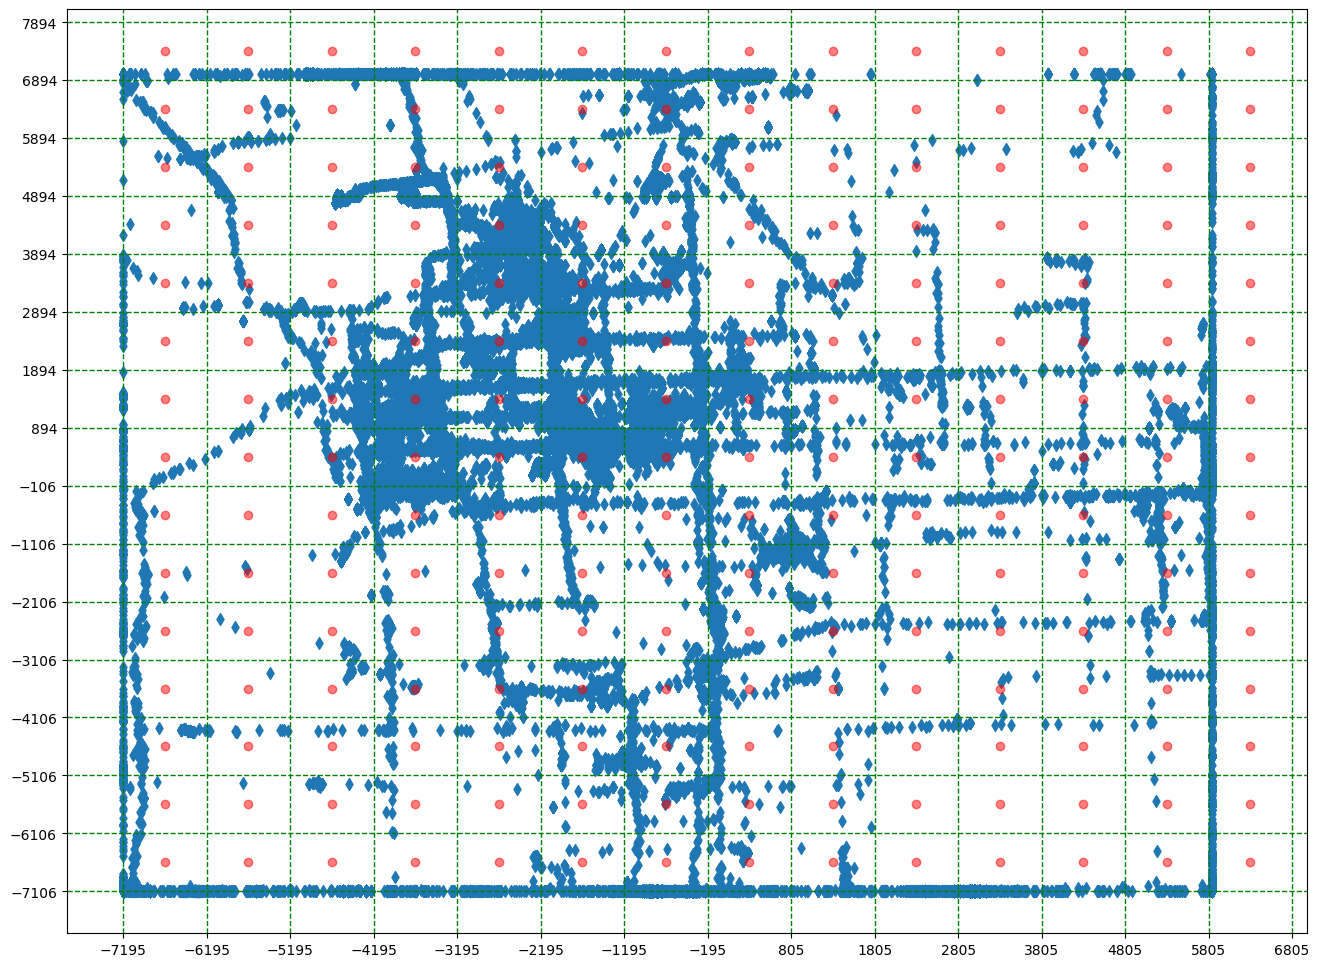

In [23]:
xcenter = cells[:,:]['x']
ycenter = cells[:,:]['y']
fig = plt.figure(figsize=(16,12))
ax = fig.gca()
xticks =np.arange(X_low,X_high+cell_dia,cell_dia)
yticks = np.arange(Y_low,Y_high+cell_dia,cell_dia)
ax.set_xticks(xticks)
ax.set_yticks(yticks)
plt.scatter(x= filled_df['x'],y=filled_df['y'],marker = 'd')
plt.scatter(x = xcenter,y = ycenter,color = 'r',alpha = .5)
plt.grid(color='g', linestyle='--', linewidth=1)
plt.show()

Cut of the timestamps that fall outside of the common trajectory duration. 

The common trajectory period is the period between the latest start time among the trajectories (which should be the same for each trajectory), and the earliest ending time among the trajectories.

In [24]:
trajectory_start_times = filled_df.groupby('user')['datetime'].agg(['min', 'max'])
period_start = trajectory_start_times['min'].max()
period_end = trajectory_start_times['max'].min()

new_df = filled_df[(filled_df['datetime'] >= period_start) & (filled_df['datetime'] <= period_end)]

Drop duplicates, if any

In [25]:
final_df = new_df.drop_duplicates(subset=['datetime', 'user'], keep='first').copy(deep=True)

# Aggregate the dataset based on the grid

Create a grid dataframe

In [26]:
locations = [x for x in cells.flatten()]
bottom_left = [(x - cell_dia/2,y - cell_dia/2) for x,y in locations]
top_right = [(x + cell_dia/2,y + cell_dia/2) for x,y in locations]
loc = [(x,y) for x,y in locations]
grid = pd.DataFrame({'ID':grid_map.values(),'towerlocation':loc,'bottomleft':bottom_left,'topright':top_right})

Put each point into a cell

In [27]:
def find_cell(value,xticks,cell_dia):
  if value == xticks[-1]:
    return (xticks[-1] - cell_dia/2)
  else:
    i = next(j for j,e in enumerate(xticks) if e > value)
    return (xticks[i-1] + cell_dia/2)

final_df.loc[:,"xcell"] = 0.0
final_df.loc[:,"ycell"] = 0.0
final_df["xcell"] = final_df["x"].apply(find_cell,args = (xticks,cell_dia))
final_df["ycell"] = final_df["y"].apply(find_cell,args = (yticks,cell_dia))

Essentially rename the cell

In [28]:
#create tuple (xcell,ycell) from xcell and ycell
final_df['tower'] = list(zip(final_df['xcell'],final_df['ycell']))
final_df.drop(['xcell','ycell'],axis = 1,inplace = True)

In [29]:
# get the cell id from the grid map
final_df.loc[:, 'cell_id'] = final_df['tower'].apply(lambda x: grid_map[x])
grouped = final_df.groupby('datetime')

This code block could potentially replace the other next 3 codeblocks, as it seems more efficient. However, since the resulting dataset is not too large, not deemed necessary

In [30]:
def process_group(group): 
    counts = group['cell_id'].value_counts()
    return counts

# agg_geolife = grouped.apply(process_group).unstack(fill_value=0)

In [31]:
df_by_index = {} #holds dataframes for each time step, each df contains which user is at which location at that time step
with tqdm(total=len(grouped), desc="Processing groups", unit="groups") as pbar:
  for indexvalue,grouped_df in grouped:
    df_by_index[indexvalue] = grouped_df
    pbar.update()

Processing groups: 100%|██████████| 5088/5088 [00:08<00:00, 572.00groups/s] 


In [32]:
col = list(grid_map.values())
agg_geolife = pd.DataFrame(0,columns = col,index = final_df['datetime'].unique())    

In [33]:
with tqdm(total=len(df_by_index.keys()), desc="Processing") as pbar:
  for index in df_by_index.keys():
    x = df_by_index[index]
    counts = x['cell_id'].value_counts().reset_index()
    counts.columns = ['cell_id','counts']
    agg_geolife.loc[index,counts['cell_id']] = np.array(counts['counts'])
    pbar.update()

Processing:   0%|          | 0/5088 [00:00<?, ?it/s]

Processing: 100%|██████████| 5088/5088 [00:20<00:00, 249.39it/s]


In [34]:
#Sanity check for total number of users at all the locations at particular timestamp
agg_geolife.sum(axis =1)

2000-01-01 00:00:00    36
2000-01-01 00:02:00    36
2000-01-01 00:04:00    36
2000-01-01 00:06:00    36
2000-01-01 00:08:00    36
                       ..
2000-01-08 01:26:00    36
2000-01-08 01:28:00    36
2000-01-08 01:30:00    36
2000-01-08 01:32:00    36
2000-01-08 01:34:00    36
Length: 5088, dtype: int64

Some minor modifications before we're ready to just print it to file

In [35]:
final_df = final_df.set_index('datetime')

In [36]:
ground_truth = final_df.groupby('user')
ground_truth = ground_truth[['user','cell_id', 'tower']]

In [38]:
w, h = ceil(fwidth/1000), ceil(flength/1000)
n_users = final_df['user'].nunique()

interval = interval_in_seconds 

dir_name = './processed'
agg_filename = f'{dir_name}/GeoLife_aggregrated-{n_users}u-{top_k}m-{w}x{h}-{interval}s.csv'
gtruth_filename = f'{dir_name}/GeoLife_ground_truth-{n_users}u-{top_k}m-{w}x{h}-{interval}s.csv'

# create dir if it doesnt exist
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

# remove if ground truth already exist
if os.path.isfile(gtruth_filename):
    os.remove(gtruth_filename)

agg_geolife.to_csv(agg_filename) # this already overwrites the file if it exists

for i, group in enumerate(ground_truth):
    user, group = group

    # first iteration, write w headers
    if not os.path.isfile(gtruth_filename):
        group.to_csv(gtruth_filename, index=False)
    else: 
        group.to_csv(gtruth_filename, mode='a', header=False, index=False)


------------------ End of working code --------------------